# Introduction to Deep Learning

**Goal** : This notebook explains the building blocks of a neural network model. 

**Data** : Data is taken from `sklearn`'s `make_moon` dataset. There are two features and and the target is a categorical variable (0/1). The aim is to devise an algorithm that correctly classifies the datapoints. 

**Aproach**: We will build the neural networks from first principles. We will create a very simple model and understand how it works. We will also be implementing backpropagation algorithm. Please note that this code is not optimized. This is for instructive purpose - for us to understand how ANN works. Libraries like `theano` have highly optimized code.
<img src="image/nn-3-layer-network.png">

In [11]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import math
import random
import string

random.seed(123)
# Display plots inline 
%matplotlib inline
# Define plot's default figure size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

   Feature1  Feature2  Target
0  2.067788  0.258133       1
1  0.993994 -0.609145       1
2 -0.690315  0.749921       0
3  1.023582  0.529003       0
4  0.700747 -0.496724       1
(500, 2) (500,)


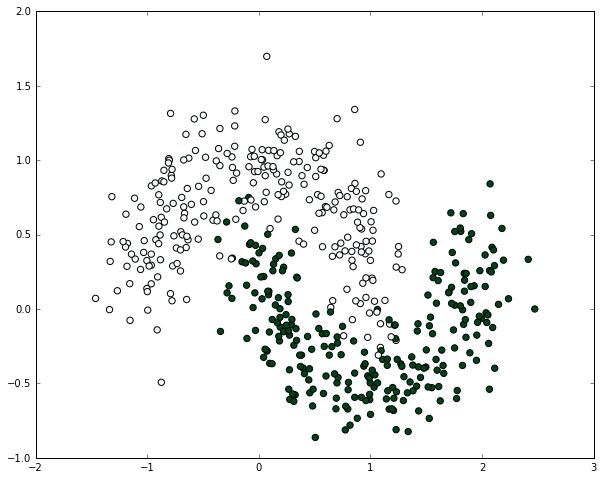

In [12]:
#read the datasets
train = pd.read_csv("data/intro_to_ann.csv")
print (train.head())
X, y = np.array(train.ix[:,0:2]), np.array(train.ix[:,2])
print(X.shape, y.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.BuGn)

## Let's start building our NN's building blocks. 

This process will eventually result in our own NN class

### Function to generate a random number, given two numbers

When we initialize the neural networks, the weights have to be randomly assigned.  

In [13]:
# calculate a random number where:  a <= rand < b
def rand(a, b):
    return (b-a)*random.random() + a

# Make a matrix 
def makeMatrix(I, J, fill=0.0):
    return np.zeros([I,J])

# our sigmoid function
def sigmoid(x):
    #return math.tanh(x)
    return 1/(1+np.exp(-x))

# derivative of our sigmoid function, in terms of the output (i.e. y)
def dsigmoid(y):
    return (y * (1- y))

### Our NN class

When we first create a neural networks architecture, we need to know the number of inputs, number of hidden layers and number of outputs.

The weights have to be randomly initialized.

In [14]:
class NN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)

In [15]:
class NN:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
        

    def backPropagate(self, targets, N, M):
        
        if len(targets) != self.no:
            print(targets)
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        #output_deltas = [0.0] * self.no
        output_deltas = np.zeros(self.no)
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # calculate error terms for hidden
        
        #hidden_deltas = [0.0] * self.nh
        hidden_deltas = np.zeros(self.nh)
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error = error + output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change
                #print N*change, M*self.co[j][k]

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5*(targets[k]-self.ao[k])**2
        return error


    def test(self, patterns):
        self.predict = np.empty([len(patterns), self.no])
        for i, p in enumerate(patterns):
            self.predict[i] = self.activate(p)
            #self.predict[i] = self.activate(p[0])

    def weights(self):
        print('Input weights:')
        for i in range(self.ni):
            print(self.wi[i])
        
        print('Output weights:')
        for j in range(self.nh):
            print(self.wo[j])
            
    def activate(self, inputs):
        
        if len(inputs) != self.ni-1:
            print(inputs)
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni-1):
            #self.ai[i] = sigmoid(inputs[i])
            self.ai[i] = inputs[i]
            
        

        # hidden activations
        for j in range(self.nh):
            sum = 0.0
            for i in range(self.ni):
                sum = sum + self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)
           
        # output activations
        for k in range(self.no):
            sum = 0.0
            for j in range(self.nh):
                sum = sum + self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)

        
        return self.ao[:]
    
    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: learning rate
        # M: momentum factor
        patterns = list(patterns)
        for i in range(iterations):
            error1 = 0.0
            #j = 0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.activate(inputs)
                error1 = error1 + self.backPropagate([targets], N, M)
                #j= j+1
                #print (j)
                #self.weights()    
            #if i % 5 == 0:
            print('error in iiteration %d : %-.5f' % (i,error1))
            #print('Final training error: %-.5f' % error1)

### Let's visualize and observe the resultset

In [16]:
# Helper function to plot a decision boundary.
# This generates the contour plot to show the decision boundary visually
def plot_decision_boundary(nn_model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    nn_model.test(np.c_[xx.ravel(), yy.ravel()])
    Z = nn_model.predict
    Z[Z>=0.5] = 1
    Z[Z<0.5] = 0
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], s=40,  c=y, cmap=plt.cm.BuGn)

## Create Neural networks with 1 hidden layer.

In [23]:
n = NN(2, 4, 1)

In [24]:
print (n.weights())

Input weights:
[-0.11725501  0.04356101  0.01082998  0.12373541]
[-0.07389474 -0.04070474  0.10771164  0.00510085]
[ 0.07393489  0.05534131  0.06666305  0.15603943]
Output weights:
[-0.05545412]
[ 0.67388089]
[-0.50191347]
[-1.87263477]
None


### Data Set
#(X1,X2) = (2.067788  0.258133),    y=1
#(X1,X2) = (0.993994  -0.609145),   y=1
#(X1,X2) = (-0.690315 0.749921),    y=0
#(X1,X2) = (1.023582  0.529003),    y=0
#(X1,X2) = (0.700747  -0.496724),   y=1

In [25]:
print ("prediction")
print ("y=1 --- yhat=",n.activate([2.067788, 0.258133]))
print ("y=1 --- yhat=",n.activate([0.993994, 0.258133]))
print ("y=0 --- yhat=",n.activate([-0.690315, 0.749921]))
print ("y=0 --- yhat=",n.activate([1.023582, 0.529003]))
print ("y=1 --- yhat=",n.activate([0.700747, -0.496724]))

prediction
y=1 --- yhat= [0.25766039880443892]
y=1 --- yhat= [0.26777235157632973]
y=0 --- yhat= [0.28237829568507083]
y=0 --- yhat= [0.26634065892326242]
y=1 --- yhat= [0.273860450282844]


## Train the Neural Networks = estimate the ws while minimizing the error

error in iiteration 0 : 34.31783
error in iiteration 1 : 25.28755
error in iiteration 2 : 24.79263
error in iiteration 3 : 24.72136
error in iiteration 4 : 24.69802
error in iiteration 5 : 24.67707
error in iiteration 6 : 24.65321
error in iiteration 7 : 24.62786
error in iiteration 8 : 24.60300
error in iiteration 9 : 24.57993
error in iiteration 10 : 24.55918
error in iiteration 11 : 24.54079
error in iiteration 12 : 24.52455
error in iiteration 13 : 24.51011
error in iiteration 14 : 24.49714
error in iiteration 15 : 24.48535
error in iiteration 16 : 24.47449
error in iiteration 17 : 24.46437
error in iiteration 18 : 24.45484
error in iiteration 19 : 24.44580
error in iiteration 20 : 24.43716
error in iiteration 21 : 24.42887
error in iiteration 22 : 24.42087
error in iiteration 23 : 24.41314
error in iiteration 24 : 24.40565
error in iiteration 25 : 24.39840
error in iiteration 26 : 24.39137
error in iiteration 27 : 24.38454
error in iiteration 28 : 24.37792
error in iiteration 29 :

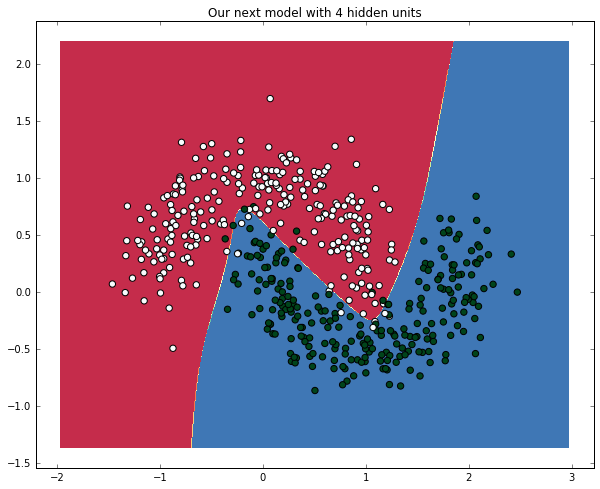

In [26]:
%timeit -n 1 -r 1 n.train(zip(X,y), iterations=1000)
plot_decision_boundary(n)
plt.title("Our next model with 4 hidden units")

In [22]:
print (n.weights())

Input weights:
[ 12.70675186  -0.20252168  -0.74290998  -0.19596548]
[-1.49198991 -8.85315023  7.05710334 -8.29617985]
[-19.85000109  -2.61742209  -3.59368972  -2.70835334]
Output weights:
[ 7.44186771]
[ 2.78666447]
[-4.31600864]
[ 2.70058949]
None


### Data Set
#(X1,X2) = (2.067788  0.258133),    y=1
#(X1,X2) = (0.993994  -0.609145),   y=1
#(X1,X2) = (-0.690315 0.749921),    y=0
#(X1,X2) = (1.023582  0.529003),    y=0
#(X1,X2) = (0.700747  -0.496724),   y=1

In [87]:
print ("prediction")
print ("y=1 --- yhat=",n.activate([2.067788, 0.258133]))
print ("y=1 --- yhat=",n.activate([0.993994, 0.258133]))
print ("y=0 --- yhat=",n.activate([-0.690315, 0.749921]))
print ("y=0 --- yhat=",n.activate([1.023582, 0.529003]))
print ("y=1 --- yhat=",n.activate([0.700747, -0.496724]))

prediction
y=1 --- yhat= [0.99906543814635684]
y=1 --- yhat= [0.013522955424105166]
y=0 --- yhat= [0.00048261392429525964]
y=0 --- yhat= [0.003109085836609233]
y=1 --- yhat= [0.99871469627279474]
